In [797]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, FundamentalMatrixTransform, rotate
from skimage.color import rgb2gray
from skimage.measure import ransac

import pandas as pd
import numpy as np
import os

In [798]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_translation_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a1]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a1
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat


def get_E_matrix(T, R):
    """
    E = [T]_x R
    """

    T_cross = get_translation_matrix(T)

    E_mat = T_cross @ R

    return E_mat

def get_F_matrix(K1, K2, E):
    """
    F = K^-T E K^-1
    """

    F_mat = np.linalg.inv(K1.T) @ E @ np.linalg.inv(K2)

    return F_mat

def get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2):
    """
    """

    P1 = K1 @ np.hstack([R1, T1])
    P2 = K2 @ np.hstack([R2, T2])

    # Calculate Pseudo-Inverse
    P1_pI = np.linalg.pinv(P1)
    
    # Camera center of the first camera
    C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
    
    # Camera center in homogenous coordinates
    C1 = np.hstack([C1, 1])
    
    # Epipole of C1 into second image
    E2 = P2 @ C1

    # Calculate F matrix
    E2_mat = get_translation_matrix(E2)
    F_mat = E2_mat @ P2 @ P1_pI

    return F_mat

In [799]:
# P1 = K1 @ np.hstack([R1, T1])
# P2 = K2 @ np.hstack([R2, T2])

# # Calculate Pseudo-Inverse
# P1_pI = np.linalg.pinv(P1)
    
# # Camera center of the first camera
# C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
# P1[:, :-1] @ C1 + P1[:, -1]
    

In [800]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')

dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

In [801]:
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

## Start with only two camera centers

In [802]:
C1_params = dino_params[1]
C2_params = dino_params[2]

In [803]:
# Calculate the Essential Matrix
    # Ci_params =  [K, R, T]

K1, R1, T1 = C1_params
K2, R2, T2 = C2_params

# R_rel = np.linalg.inv(R1) @ R2
# T_rel = T1-T2 #doing T2-T1 makes normal vector face down?


# E = get_E_matrix(T = T_rel, R = R_rel)
# # Calculate the Fundamental Matrix using K^-T E K^T
# F = get_F_matrix(K1, K2, E)

F = get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2)

F

array([[ 3.61046213e-04,  5.18721343e-02,  8.26202536e+02],
       [ 4.88602923e-02, -5.27903923e-04, -6.56699958e+01],
       [-8.48974600e+02, -6.06721180e+01,  2.80184244e+04]])

In [804]:
def get_bound_box_intensities(im, point, bounding_box_size):
    u, v_dec = int(point[0]), point[1]
    v_ceil, v_floor = int(np.ceil(v_dec)), int(np.floor(v_dec))

    i = bounding_box_size//2

    im_cropped_list = []

    for v in [v_ceil, v_floor]:
        w_min, w_max = u - i, u + i
        h_min, h_max = v - i, v + i

        im_cropped_list.append(im[h_min:(h_max+1), w_min:(w_max+1), :])

    return im_cropped_list[0], v_ceil, im_cropped_list[1], v_floor

In [805]:
def loss_function_default(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    # Photoconsistency hovers around [0.1, 12]
    # Positional Consistency hovers around [30, 600] (divide by 100 maybe?)
    loss = 70*np.sum(np.abs(imL_cropped - imR_cropped)) + np.sum(np.linalg.norm(image_point - image_point_2))

    return loss

In [806]:
def get_right_epipolar_line(imR, x1, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x1_homo = np.append(x1, np.ones(len(x1))[:,None], axis = 1) 
    
    l2 = x1_homo @ F.T

    u = np.repeat(np.array([0, imR.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l2, u)

    return u, v, l2

In [807]:
def get_left_epipolar_line(imL, x2, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x2_homo = np.append(x2, np.ones(len(x2))[:,None], axis = 1) 
    
    l1 = x2_homo @ F

    u = np.repeat(np.array([0, imL.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l1, u)

    return u, v, l1

In [808]:
def get_right_image_point(image_point, imL_cropped, x2_on_eline, loss_function = loss_function_default):
    final_image_point_2_list, final_loss_list = [], []

    for i in range(len(x2_on_eline)):
        # Testing if current point on epipolar line in image 2 works
        image_point_2 = x2_on_eline[i, :]
        
        # Return the (bounding_box_size x bounding_box_size x 3)
        imR_cropped_ceil, v_ceil, imR_cropped_floor, v_floor = get_bound_box_intensities(imR, image_point_2, bounding_box_size)

        # Custom loss functino
        image_point_2_list= [np.array([image_point_2[0], v_ceil]), np.array([image_point_2[0], v_floor])]
        
        # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
        loss_list = [loss_function(image_point, image_point_2_list[0], imL_cropped, imR_cropped_ceil), \
                        loss_function(image_point, image_point_2_list[1], imL_cropped, imR_cropped_floor)]

        loss_arg = np.argmin(loss_list)
        
        image_point_2 = image_point_2_list[loss_arg]
        loss = loss_list[loss_arg]
        
        final_image_point_2_list.append(image_point_2)
        final_loss_list.append(loss)
    
    final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]

    return final_R_point

In [809]:
def get_match_points(imL, x1, F, bounding_box_size, loss_function_default):

    # Define some common variables:
        # after rotating img:(480 x 640 x 3)
    h,w,c = np.shape(imL)
    u = np.arange(w)

    u2_list, v2_list, l2_list = get_right_epipolar_line(imR, x1, F)

    x2_list = []
    for i in range(len(x1)):
        # (v, u) flipped coordinates
        image_point = np.array([x1[i, 0], x1[i, 1]])

        # l2 corresponding with the image_point
        l2 = l2_list[i,:]

        # Generate all points on epipolar line projected from first image plane
        a = -l2[0]/l2[1]
        b = -l2[2]/l2[1]

        # Produce all the points on the epipolar line
        u2 = np.arange(w)
        v2 = a*u+b
        
        # Extract all the points on the epipolar line that are within the image (and not restricted by the bounding_box_size)
        idx = np.where((v2 > bounding_box_size)&(v2 < h-bounding_box_size)& \
                (u2 > bounding_box_size)&(u2 < w-bounding_box_size))[0]
                
        u2 = u2[idx]
        v2 = v2[idx]

        
        # Stack the individual coordinates to make (n x 2) vector
        x2_on_eline = np.vstack([u2, v2]).T
        
        # For giving image_point and bounding_box_size return cropped array
        imL_cropped, v, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)


        # Return final_R_point on the right image that is closest to image_point on the left image
        final_R_point = get_right_image_point(image_point, imL_cropped, x2_on_eline, loss_function_default) 

        x2_list.append(final_R_point)

    x2 = np.array(x2_list)
    
    u1_list, v1_list, _ = get_left_epipolar_line(imL, x2, F)

    return x2, u1_list, v1_list, u2_list, v2_list

In [810]:
def get_match_points_linspace(imL, x1, F, bounding_box_size, loss_function):

    # Define some common variables:
        # after rotating img:(480 x 640 x 3)
    h,w,c = np.shape(imL)
    u = np.linspace(0, w, num = 5*w)

    u2_list, v2_list, l2_list = get_right_epipolar_line(imR, x1, F)

    x2_list = []
    for i in range(len(x1)):
        # (v, u) flipped coordinates
        image_point = np.array([x1[i, 0], x1[i, 1]])

        # l2 corresponding with the image_point
        l2 = l2_list[i,:]

        # Generate all points on epipolar line projected from first image plane
        a = -l2[0]/l2[1]
        b = -l2[2]/l2[1]

        # Produce all the points on the epipolar line
        #u2 = np.arange(w)
        u2 = np.linspace(0, w, num = 5*w)
        v2 = a*u+b
        
        # Extract all the points on the epipolar line that are within the image (and not restricted by the bounding_box_size)
        idx = np.where((v2 > bounding_box_size)&(v2 < h-bounding_box_size)& \
                (u2 > bounding_box_size)&(u2 < w-bounding_box_size))[0]
                
        u2 = u2[idx]
        v2 = v2[idx]

        
        # Stack the individual coordinates to make (n x 2) vector
        x2_on_eline = np.vstack([u2, v2]).T
        
        # For giving image_point and bounding_box_size return cropped array
        imL_cropped, v, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)
        

        # Return final_R_point on the right image that is closest to image_point on the left image
        final_R_point = get_right_image_point(image_point, imL_cropped, x2_on_eline, loss_function) 

        x2_list.append(final_R_point)

    x2 = np.array(x2_list)
    
    u1_list, v1_list, _ = get_left_epipolar_line(imL, x2, F)

    return x2, u1_list, v1_list, u2_list, v2_list

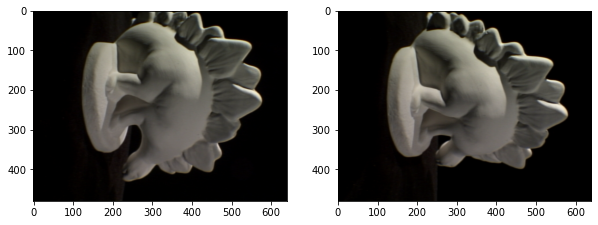

In [811]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0002.png")
imR = image.imread("dinoSparseRing/dinoSR0003.png")

# imL = rotate(imL, angle = 90)
# imR = rotate(imR, angle = 90)

imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

In [812]:
# SAMPLE RANDOM INDICES
h,w,c = np.shape(imL)
# Keep this an odd number to make things easier
bounding_box_size = 17
num_feature_points = 5

mask_dino = np.where(np.sum(imL, axis = 2) > 0.4, 1, 0)
mask_dino = np.where(mask_dino == 1)

points = np.array([mask_dino[1], mask_dino[0]]).T

mask_boundary = np.where((points[:, 0] > bounding_box_size)&(points[:,0] < w-bounding_box_size)& \
                            (points[:,1] > bounding_box_size)&(points[:,1] < h-bounding_box_size))
points = points[mask_boundary]

idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)

x1 = points[idx]

In [813]:
def loss_function_mike(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    photo_con_loss = np.sum(np.abs(imL_cropped - imR_cropped))
    pos_loss = np.sum(np.abs(image_point[1] - image_point_2[1]))

    print(photo_con_loss, 3*pos_loss)
    loss = photo_con_loss + 3*pos_loss

    return loss

In [814]:
x2, u1_list, v1_list, u2_list, v2_list = get_match_points_linspace(imL, x1, F, bounding_box_size, loss_function=loss_function_mike)

342.51373 837.0
349.8745 840.0
309.00394 825.0
318.66275 828.0
259.102 813.0
272.39215 816.0
217.69803 804.0
231.8706 807.0
178.42352 792.0
189.23138 795.0
150.73727 783.0
159.96863 786.0
124.54903 771.0
128.99608 774.0
123.56078 762.0
122.28235 765.0
132.53726 750.0
130.6353 753.0
126.65883 741.0
130.64314 744.0
119.27843 729.0
119.494125 732.0
119.76077 720.0
119.33726 723.0
119.9098 708.0
119.882355 711.0
125.57254 699.0
122.49804 702.0
157.39607 687.0
150.66667 690.0
168.26666 678.0
165.81961 681.0
168.69412 666.0
169.82355 669.0
163.93332 657.0
166.07059 660.0
152.24706 645.0
155.12157 648.0
142.25491 636.0
144.8902 639.0
134.53333 624.0
135.70981 627.0
131.8902 615.0
132.08627 618.0
144.22353 603.0
138.13725 606.0
176.65489 591.0
167.9098 594.0
203.62354 582.0
194.56079 585.0
242.75294 570.0
232.54507 573.0
272.9255 561.0
263.23138 564.0
292.32156 549.0
290.0353 552.0
294.95688 540.0
294.6941 543.0
286.83533 528.0
290.45883 531.0
272.5412 519.0
277.60394 522.0
248.40393 507.0
254

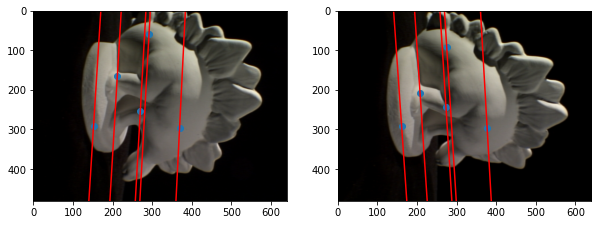

In [815]:
# ------------------------------------ #
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 0], x1[:, 1])
for i in range(num_feature_points): 
    ax81.plot(u1_list[i], v1_list[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
# ------------------------------------ #
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(x2[:, 0], x2[:, 1])
for i in range(num_feature_points): 
    ax82.plot(u2_list[i], v2_list[i], '-r') 
    ax82.set_xlim((0, imR.shape[0])) 
    ax82.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
# ------------------------------------ #
plt.show()

In [816]:
# GOOD PLOTTING CODE FOR ONE LOSS FUNCTION

# plt.figure(0,figsize = (10, 4))
# ax81 = plt.subplot(121)
# plt.imshow(imL)
# plt.scatter(x1[:, 0], x1[:, 1])
# for i in range(num_feature_points): 
#     ax81.plot(u1_list[i], v1_list[i], '-r') 
#     ax81.set_xlim((0, imR.shape[0])) 
#     ax81.set_ylim((imR.shape[1], 0)) 

# plt.xlim(0, w)
# plt.ylim(h, 0)
# ax82 = plt.subplot(122)
# plt.imshow(imR)
# plt.scatter(x2[:, 0], x2[:, 1])
# for i in range(num_feature_points): 
#     ax82.plot(u2_list[i], v2_list[i], '-r') 
#     ax82.set_xlim((0, imR.shape[0])) 
#     ax82.set_ylim((imR.shape[1], 0)) 

# plt.xlim(0, w)
# plt.ylim(h, 0)
# plt.show()

# Garbage from here and below

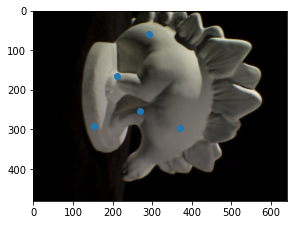

<function loss_function_default at 0x7f8370b3ddc0>


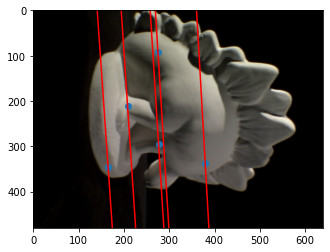

<function loss_function_pc at 0x7f8338ad9940>


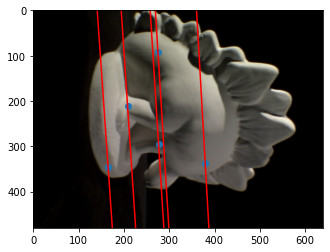

<function loss_function_pos at 0x7f8370a3c160>


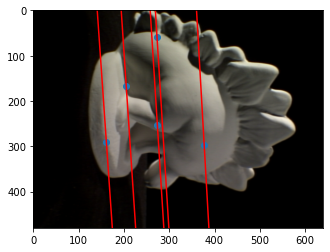

<function loss_function_pcmore at 0x7f8338ad9310>
342.51373 286.6870897155361
349.8745 287.6870897155361
309.00394 282.48702719599873
318.66275 283.48702719599873
259.102 278.28696467646137
272.39215 279.28696467646137
217.69803 275.086902156924
231.8706 276.086902156924
178.42352 270.8868396373867
189.23138 271.8868396373867
150.73727 267.6867771178493
159.96863 268.6867771178493
124.54903 263.48671459831195
128.99608 264.48671459831195
123.56078 260.2866520787746
122.28235 261.2866520787746
132.53726 256.08658955923727
130.6353 257.08658955923727
126.65883 252.8865270396999
130.64314 253.8865270396999
119.27843 248.68646452016253
119.494125 249.68646452016253
119.76077 245.48640200062516
119.33726 246.48640200062516
119.9098 241.28633948108785
119.882355 242.28633948108785
125.57254 238.08627696155048
122.49804 239.08627696155048
157.39607 233.8862144420131
150.66667 234.8862144420131
168.26666 230.68615192247574
165.81961 231.68615192247574
168.69412 226.48608940293838
169.82355 227

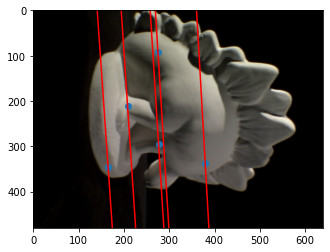

In [817]:
def loss_function_pc(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    loss = np.sum(np.abs(imL_cropped - imR_cropped))

    return loss

def loss_function_pos(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    loss = np.sum(np.abs(image_point - image_point_2))

    return loss

def loss_function_pcmore(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    loss = 100*np.sum(np.abs(imL_cropped - imR_cropped)) + np.sum(np.abs(image_point - image_point_2))
    print(np.sum(np.abs(imL_cropped - imR_cropped)), np.sum(np.abs(image_point - image_point_2)))

    return loss


d = {}
i = 0 

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 0], x1[:, 1])
plt.xlim(0, w)
plt.ylim(h, 0)
plt.show()

for loss in [loss_function_default, loss_function_pc, loss_function_pos, loss_function_pcmore]:
    print(loss)
    x2, u1_list, v1_list, u2_list, v2_list = get_match_points_linspace(imL, x1, F, bounding_box_size, loss_function = loss)
    plt.imshow(imR)
    plt.scatter(x2[:, 0], x2[:, 1])
    for i in range(num_feature_points): 
        plt.plot(u2_list[i], v2_list[i], '-r') 
    plt.xlim(0, w)
    plt.ylim(h, 0)
    plt.show()

In [818]:
u2_list, v2_list = get_match_points_TEST(imL, x1, F, bounding_box_size)
u_list, v_list, l2_list = get_right_epipolar_line(imR, x1, F)




ValueError: too many values to unpack (expected 2)

In [ ]:
print(bounding_box_size)

idx = np.where((v2_list > bounding_box_size)&(v2_list < h-bounding_box_size)& \
                (u2_list > bounding_box_size)&(u2_list < w-bounding_box_size))[0]

3


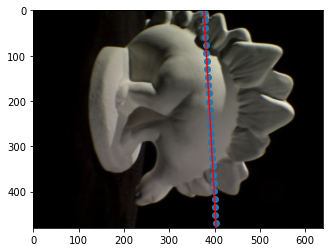

In [ ]:
plt.imshow(imR)
plt.scatter(u2_list[idx], v2_list[idx])
plt.plot(u_list[0], v_list[0], '-r') 

plt.xlim(0, w)
plt.ylim(h, 0)
plt.show()

In [ ]:
u2_list[0], v2_list[0], u2_list[-1], v2_list[-1]

(0, -6747.825652637129, 639, 4696.571300270253)

In [ ]:
u_list, v_list

(array([[  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640]]),
 array([[-7418.79471698,  4362.45689959],
        [-7591.87948518,  4271.64788941],
        [-7971.87052041,  4072.2854028 ],
        [-3462.58937541,  6438.08201001],
        [-3734.70391339,  6295.31698161],
        [-2439.08977539,  6975.06158687],
        [-4739.68769251,  5768.05173944],
        [-3122.538295  ,  6616.48997936],
        [-4290.98022796,  6003.46633505],
        [-3428.28579264,  6456.07940186]]))

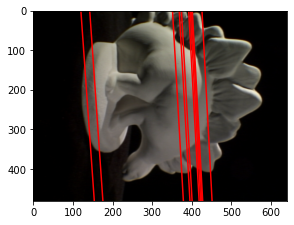

In [ ]:
u_list, v_list, l2_list = get_right_epipolar_line(imR, x1, F)

plt.figure(0,figsize = (10, 4)) 
ax81 = plt.subplot(121) 
plt.imshow(imR) 
for i in range(num_feature_points): 
    ax81.plot(u_list[i], v_list[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w) 
plt.ylim(l, 0) 
plt.show()

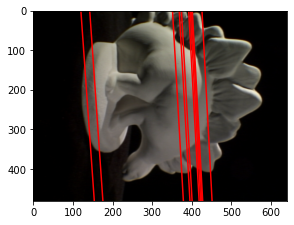

In [ ]:
## Jack's little debugging space 
# # a. create an array of homogeneous points sampled in images 1 and 2 
ptsL_sample_homo = np.append(x1, np.ones(num_feature_points)[:,None], axis = 1) 
# b. create an array of the corresponding epipolar lines in images 1 and 2 
l2_sample = np.dot(ptsL_sample_homo, F.T) # Predict Y coordinates matrix given X matrix 
def predict_y(l, x): 
    a = -np.divide(l[:,0], l[:,1]) 
    b = -np.divide(l[:,2], l[:,1]) 
    return np.multiply(a[:,None], x) + b[:,None] 

ends = np.repeat(np.array([0, imR.shape[1]])[None,:], num_feature_points, axis=0) 
imR_y = predict_y(l2_sample, ends)

plt.figure(0,figsize = (10, 4)) 
ax81 = plt.subplot(121) 
plt.imshow(imR) 
for i in range(num_feature_points): 
    ax81.plot(ends[i], imR_y[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w) 
plt.ylim(l, 0) 
plt.show()

NameError: name 'u' is not defined

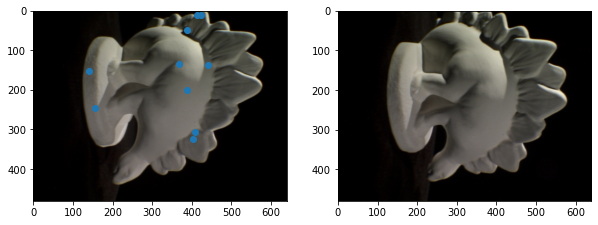

In [ ]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 0], x1[:, 1])
# for i in range(len(e_L)):
#     plt.plot(e_L[i][1], e_L[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
ax82 = plt.subplot(122)
plt.imshow(imR)
# plt.scatter(R_points[:, 1], R_points[:, 0])
for i in range(len(u)):
    plt.plot(u[i,:], v[i,:])
plt.xlim(0, w)
plt.ylim(l, 0)
plt.show()

In [ ]:
R_points, e_L, e_R = get_match_points(imL, imR, x1, F, bounding_box_size)

ValueError: attempt to get argmin of an empty sequence

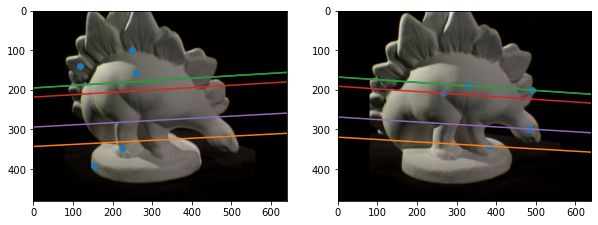

In [ ]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 1], x1[:, 0])
for i in range(len(e_L)):
    plt.plot(e_L[i][1], e_L[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(R_points[:, 1], R_points[:, 0])
for i in range(len(e_R)):
    plt.plot(e_R[i][1], e_R[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
plt.show()

In [ ]:
# # Map these indices to the second image using F
# x1_homo = np.hstack([x1, np.ones(shape=(len(x1), 1), dtype=int)])
# x1_homo


# # each column represents the coefficients of line equation of l1 = Fx2
# Fx = np.dot(F, x1_homo.T)

# final_R_points_list = []
# epipolar_line_L_list = []
# epipolar_line_R_list = []
# u = np.arange(l-1)
# v = np.arange(w-1)
# for i in range(len(x1)):
    
#     original_L_point = np.array([x1[i, 0], x1[i, 1]])
#     l1 = Fx[:, i]
#     u_pt_on_l1_not_int = -(1/l1[0])*(v*l1[1]+l1[2])
    
#     u_pt_on_l1 = np.around(u_pt_on_l1_not_int.astype('int'))
    

#     # Indices of the second image
#     x2_on_eline = np.vstack([u_pt_on_l1, v]).T
#     # # Location out NOT out of bounds
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] > bounding_box_size, :]

#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] < w - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] > bounding_box_size, :]
    
#     if len(x2_on_eline) != 0:
#         epipolar_line_R_list.append([u_pt_on_l1_not_int, v])
#         bb_int_L = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
#         loss_list = []
#         for i in range(len(x2_on_eline)):
            
#             point = x2_on_eline[i, :]
#             bb_int_R = get_bound_box_intensities(imR, point, bounding_box_size)

#             if len(bb_int_R) != 0:

#                 loss = np.sum(np.square(bb_int_L - bb_int_R)) + (1/2)*np.sum(np.abs(original_L_point - point))
#                 loss_list.append(loss)

#         final_R_point = x2_on_eline[np.argmin(loss_list), :]
#         xF = np.dot((np.hstack([final_R_point, 1])).T, F)
#         l2 = xF
#         v_pt_on_l2_not_int = -(1/l2[1])*(u*l2[0]+l2[2])
#         epipolar_line_L_list.append([u, v_pt_on_l2_not_int])

#         final_R_points_list.append(final_R_point)

# final_R_points = np.array(final_R_points_list)



In [ ]:
mask[(x1[:, 0], x1[:, 1])]

# x1[0, 0], x1[0, 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# proper_points_list = []

# i = 0

# original_L_point = np.array([x1[i, 0], x1[i, 1]])
# l1 = Fx[:, i]
# u_pt_on_l1 = -(1/l1[0])*(v*l1[1]+l1[2])
# u_pt_on_l1 = np.around(u_pt_on_l1.astype('int'))


# # Indices of the second image
# x2_on_eline = np.vstack([u_pt_on_l1, v]).T
# # Location out NOT out of bounds
# x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l, :]

# # Intensity values of the 3 channels
# vec = imL[x2_on_eline[:,0],x2_on_eline[:,1], :]

# # Location of not BLACK areas
# bool_not_all_zeros = ~np.all(vec == 0, axis = 1)

# # Indices where not black and not out of bounds
# x2_on_eline = x2_on_eline[bool_not_all_zeros]

# bb_int_L, original_L_point = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
# loss_list = []
# for i in range(len(x2_on_eline)):
#     point = x2_on_eline[i, :]
#     bb_int_R, point_R = get_bound_box_intensities(imR, point, bounding_box_size)

#     loss = np.sum(np.square(bb_int_L - bb_int_R))
#     loss_list.append(loss)

# proper_points_list.append(x2_on_eline[np.argmin(loss_list), :])









In [ ]:
mse

2.71674

In [ ]:
bool_not_all_zeros

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

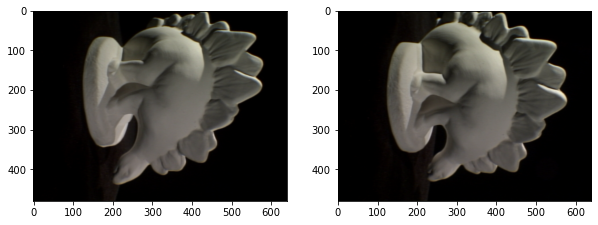

In [ ]:
# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0001.png")
imR = image.imread("dinoSparseRing/dinoSR0002.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

the number of features in images 1 and 2 are    39 and    36


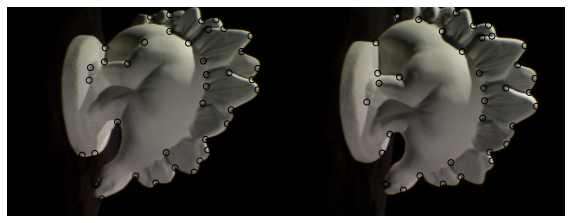

In [ ]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

the number of matches is 24


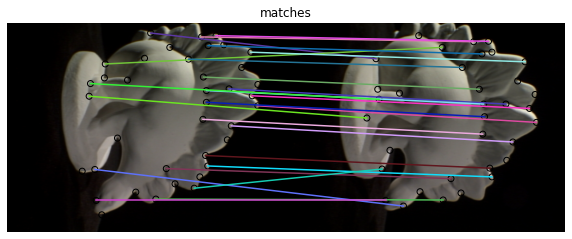

In [ ]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

the number of inliers is  9


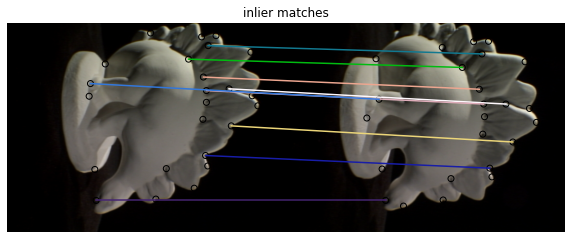

In [ ]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()